# **Importing Data**

In [2]:
import os
from PIL import Image, ImageFilter

women_dataset = 'D:/CUFE_Courses/3-Senior1/Spring2023/CMPN450_Pattern-Recognition-&-Neural-Networks/Project/Dataset_0-5/Women'
men_dataset = 'D:/CUFE_Courses/3-Senior1/Spring2023/CMPN450_Pattern-Recognition-&-Neural-Networks/Project/Dataset_0-5/men'

images_paths = []
# dataset_labels = []
classes_sizes=[]
corrupted=0
corrupted_imgs=[]
for i in range(6):
  women_folder_path = os.path.join(women_dataset, str(i))
  men_folder_path = os.path.join(men_dataset, str(i))
  # Get the file paths in the folders
  women_files = [os.path.join(women_folder_path, f) for f in os.listdir(women_folder_path) if os.path.isfile(os.path.join(women_folder_path, f))]
  men_files = [os.path.join(men_folder_path, f) for f in os.listdir(men_folder_path) if os.path.isfile(os.path.join(men_folder_path, f))]

  imgs = women_files + men_files
  for img in imgs:
    if not img.endswith(".JPG"):          # in case of desktop.ini file or any other file
        continue

    try:
        temp = Image.open(img)
    except (IOError, SyntaxError) as e:   # in case of corrupted images
        print('Bad file:', temp)
        corrupted+=1
        continue 
    path = img.split('/')
    images_paths.append(img)
    
    
  classes_sizes.append(len(imgs))    
print("Total number of images = ", len(images_paths))
print("Number of corrupted images or desktop.ini file = ", corrupted)
print("Number of images per class = ", classes_sizes)

Bad file: <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=4608x2592 at 0x292945586A0>
Bad file: <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=4608x2592 at 0x292945586A0>
Bad file: <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=4608x2592 at 0x2929348AAD0>
Bad file: <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=4608x2592 at 0x2929348AAD0>
Bad file: <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=4608x2592 at 0x292945710C0>
Bad file: <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=4608x2592 at 0x2929335EBF0>
Total number of images =  1821
Number of corrupted images or desktop.ini file =  6
Number of images per class =  [289, 302, 312, 320, 305, 311]


In [3]:
import random

random.seed(7)
random.shuffle(images_paths)
dataset_labels = []
for img in images_paths:
  path=img.split('/')[-1].split('\\')
  dataset_labels.append(path[1])

# **Splitting Data (Training 70%, Validation 10%, Testing 20%)**

In [4]:
from sklearn.model_selection import train_test_split

# splitting training into 80% and testing into 20%
train_paths, test_paths, train_labels, test_labels = train_test_split(images_paths, dataset_labels, test_size=0.2, random_state=42, stratify=dataset_labels)

# splitting training into 70% and validation into 10%
train_paths, validation_paths, train_labels, validation_labels = train_test_split(train_paths, train_labels, test_size=0.1, random_state=42, stratify=train_labels)

print(len(train_paths), len(validation_paths), len(test_paths))

# check
total = len(train_paths) + len(validation_paths) + len(test_paths)
print(total == len(images_paths))

1310 146 365
True


# **Image Pre-processing**

In [5]:
import numpy as np
import cv2 as cv

# Define the target size for the images
target_size = (200, 200)

def image_preprocess(img_path):
    # Load the image
    image = cv.imread(img_path)

    # Resize the image to the target size
    resized_img = cv.resize(image, target_size)

    # Convert the resized image to grayscale
    gray_img = cv.cvtColor(resized_img, cv.COLOR_BGR2GRAY)

    # Normalize the pixel values to be between 0 and 1
    # normalized_img  = gray_img / 255.0
    normalized_img = (gray_img - np.min(gray_img)) * 255.0 / (np.max(gray_img) - np.min(gray_img))

    return resized_img, gray_img, normalized_img    # return the original and the preprocessed images


In [187]:
def shadow_remover(img):

    # Convert the image to YCrCb color space
    img_ycrcb = cv.cvtColor(img, cv.COLOR_BGR2YCrCb)

    # Define the skin tone range
    lower_skin = np.array([0, 134, 85])
    upper_skin = np.array([255, 180, 135])

    # Create a mask using the skin tone range
    skin_mask = cv.inRange(img_ycrcb, lower_skin, upper_skin)

    # Invert the mask to select non-skin pixels
    non_skin_mask = cv.bitwise_not(skin_mask)

    # Apply median blur to the non-skin pixels to remove noise
    non_skin_mask = cv.medianBlur(non_skin_mask, 21)

    # Apply the non-skin mask to the original image to select the shadowed pixels
    shadow_mask = cv.bitwise_and(img, img, mask=non_skin_mask)

    # Calculate the mean brightness of the shadowed pixels
    mean_value = np.mean(shadow_mask)

    # Calculate the brightness ratio between the shadowed pixels and the skin pixels
    ratio = 255 / mean_value

    # Apply the ratio to the skin pixels to adjust their brightness
    skin_mask = cv.multiply(skin_mask, ratio)

    # Combine the skin mask and non-skin mask to create the final mask
    final_mask = cv.add(skin_mask, non_skin_mask)

    # Apply the final mask to the original image to remove the shadows
    img_output = cv.bitwise_and(img, img, mask=final_mask)


    return img_output

Image shape after preprocessing =  (200, 200)


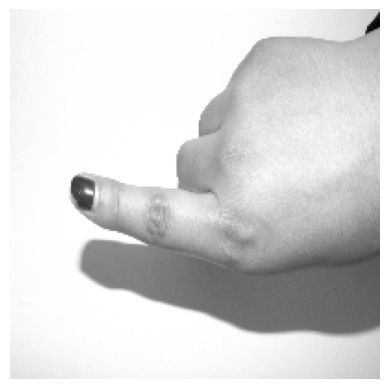

True

In [6]:
import matplotlib.pyplot as plt

resized, gray, norm = image_preprocess(images_paths[167])
print("Image shape after preprocessing = ", norm.shape)

# Display the original and processed images
# cv.imshow('Original Image', norm)
plt.axis("off")
plt.imshow(norm, cmap='gray')
plt.show()
cv.imwrite("Preprocessed_Image.JPG", norm)

# **Image Segmentation**

In [189]:
uint8_img = norm.astype(np.uint8)

shadow_removed =shadow_remover(resized)
cv.imwrite('shadows_out.png', shadow_removed)

True

In [12]:
def image_segmentation(img):
    # Apply Gaussian blur to remove noise (optional)
    img = cv.GaussianBlur(img, (5, 5), 0)

    # Apply Otsu's thresholding to get binary image
    # _, thresh = cv.threshold(img, 75, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
    # thresh = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY,11,2)

    hsvim = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    lower = np.array([0, 48, 80], dtype = "uint8")
    upper = np.array([20, 255, 255], dtype = "uint8")
    skinRegionHSV = cv.inRange(hsvim, lower, upper)
    ret,thresh = cv.threshold(skinRegionHSV,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)

    return thresh

In [13]:
# Convert the normalized image to uint8
# uint8_img = cv.convertScaleAbs(norm, alpha=(255.0))
uint8_img = norm.astype(np.uint8)

segmented_img = image_segmentation(resized)
print("Image shape after segmentation = ", segmented_img.shape)
cv.imwrite("Segmented_Image.JPG", segmented_img)

Image shape after segmentation =  (200, 200)


True

# **Morphological Operations**

In [14]:
def morphological_operations(img):
    # Define the kernel for morphological operations
    kernel = np.ones((5,5),np.uint8)

    # Perform dilation operation on the image
    dilated_img = cv.dilate(img, kernel, iterations=1)

    # Perform erosion operation on the image
    eroded_img = cv.erode(img, kernel, iterations=1)

    # Perform opening operation on the image
    opening_img = cv.morphologyEx(img, cv.MORPH_OPEN, kernel)

    # Perform closing operation on the image
    closing_img = cv.morphologyEx(img, cv.MORPH_CLOSE, kernel)

    return closing_img

In [ ]:
# noise_removal = morphological_operations(segmented_img)
# print("Image shape after morphological operations = ", noise_removal.shape)
# cv.imwrite("Noise_Removal_Image.JPG", noise_removal)

noise_removal = morphological_operations(shadow_removed)
print("Image shape after morphological operations = ", noise_removal.shape)
cv.imwrite("Noise_Removal_Image.JPG", shadow_removed)

In [194]:
def invert_black(img):
    grey_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # Find all black pixels using boolean indexing
    black_pixels = grey_img == 0

    # Set the black pixels to white using boolean indexing
    grey_img[black_pixels] = 255

    return grey_img

In [195]:
def Enhancing_Image(img):
    inverted_Img = invert_black(img)

    grey_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # Subtract the two images to get the shadow mask
    shadow_mask = cv.absdiff(grey_img, inverted_Img)

    # Apply a threshold to the shadow mask to create a binary mask
    ret, binary_mask = cv.threshold(shadow_mask, 50, 255, cv.THRESH_BINARY)

    # Invert the binary mask
    binary_mask_inv = cv.bitwise_not(binary_mask)

    # Apply the binary mask to the original image to remove the shadow
    result = cv.bitwise_and(resized, resized, mask=binary_mask_inv)

    segmented_img = image_segmentation(result)

    return segmented_img

In [196]:
segmented_img = Enhancing_Image(noise_removal)
cv.imwrite('Segmented_Image.png', segmented_img)

True

# **Skeletonize**

In [494]:
from skimage.morphology import skeletonize
from skimage import data
import matplotlib.pyplot as plt
from skimage.util import invert

def skeletonize_image(img):
    # perform skeletonization

    skeleton = skeletonize(img)

    # display results
    # fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), sharex=True, sharey=True)

    # ax = axes.ravel()

    # ax[0].imshow(noise_removal, cmap=plt.cm.gray)
    # ax[0].axis('off')
    # ax[0].set_title('original', fontsize=20)

    # ax[1].imshow(skeleton, cmap=plt.cm.gray)
    # ax[1].axis('off')
    # ax[1].set_title('skeleton', fontsize=20)

    # fig.tight_layout()
    # plt.show()
    
    return skeleton

# **Canny Edge Detection**

In [15]:
def canny_edge_detection(img):
    # Apply Gaussian blur to reduce noise in the image
    img_blur = cv.GaussianBlur(img, (5,5), 0)

    # Perform Canny edge detection
    edges = cv.Canny(img_blur, 100, 200)

    return edges

In [16]:
# edges = canny_edge_detection(noise_removal)
# print("Image shape after Canny edge detection = ", edges.shape)
# cv.imwrite("Edged_Image.JPG", edges)

edges = canny_edge_detection(segmented_img)
cv.imwrite("Edged_Image.JPG", edges)


True

# **Feature Extraction**

In [17]:
def EOH(img):
    # Compute the gradient magnitude and direction using Sobel operators
    dx = cv.Sobel(img, cv.CV_32F, 1, 0)
    dy = cv.Sobel(img, cv.CV_32F, 0, 1)
    mag, angle = cv.cartToPolar(dx, dy, angleInDegrees=True)

    # Define the number of histogram bins and range
    hist_bins = 9
    hist_range = (0, 180)

    # Compute the histogram of gradient orientations for each cell of a 4x4 grid
    cell_size = (img.shape[0] // 4, img.shape[1] // 4)
    hog_descriptor = np.zeros((4, 4, hist_bins))
    for i in range(4):
        for j in range(4):
            cell_mag = mag[i*cell_size[0]: (i+1)*cell_size[0], j*cell_size[1]: (j+1)*cell_size[1]]
            cell_angle = angle[i*cell_size[0]: (i+1)*cell_size[0], j*cell_size[1]: (j+1)*cell_size[1]]
            hist, _ = np.histogram(cell_angle, bins=hist_bins, range=hist_range, weights=cell_mag)
            hog_descriptor[i, j] = hist

    # Flatten the descriptor to obtain a feature vector for the entire image
    hog_descriptor = hog_descriptor.flatten()

    # Normalize the feature vector using L2 normalization
    hog_descriptor /= np.linalg.norm(hog_descriptor)

    return hog_descriptor

In [18]:
features = EOH(edges)
print("Features vector shape = ", features.shape)
print("Features vector = ", features)

Features vector shape =  (144,)
Features vector =  [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.1310919  0.00744625 0.21427862 0.04212234 0.0899117  0.00526529
 0.00470942 0.         0.00333006 0.         0.         0.05415833
 0.06446108 0.23310442 0.02106117 0.01177355 0.         0.
 0.00526529 0.         0.01883768 0.01053058 0.01332025 0.01271154
 0.03767536 0.00744625 0.01386065 0.09625779 0.01489249 0.03767536
 0.05701483 0.19314367 0.08116033 0.06357717 0.         0.09099249
 0.22820413 0.02233874 0.25195399 0.10440246 0.11655221 0.02015779
 0.05180362 0.01489249 0.10624798 0.10152308 0.00744625 0.18366739
 0.17194787 0.16983322 0.01579588 0.0706413  0.01489249 0.13396927
 0.10012825 0.00744625 0.10360725 0.03377271 0.07326139 0.11621062
 0.20250507 0.02233874 0.05629703 0.08293753 0.00744625 0.05415833
 0.04648425 0.38628732 0.24693953 0.1789579

# **HOG**

In [495]:
from skimage.feature import hog

def HOG_image(img):
    # Define HOG parameters
    orientations = 9
    pixels_per_cell = (8, 8)
    cells_per_block = (2, 2)
    block_norm = 'L2-Hys'

    # Calculate HOG features
    hog_features = hog(img, orientations=orientations, pixels_per_cell=pixels_per_cell,
                    cells_per_block=cells_per_block, block_norm=block_norm, visualize=False)

    return hog_features


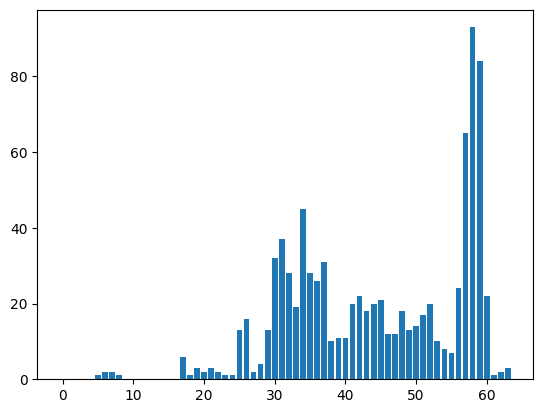

In [19]:
# Initialize number of histogram bins
k = 64
bin_width = 256 // k

# Initialize histogram bins
histogram = np.zeros(k, dtype=np.int32)

# Loop over every edge pixel in Iedge
for i in range(edges.shape[0]):
    for j in range(edges.shape[1]):
        # Check if the pixel is an edge pixel
        if edges[i, j] != 0:
            # Find corresponding gray level intensity in Igray
            intensity = gray[i, j]
            # Determine the bin index for the intensity
            bin_index = intensity // bin_width
            # Increment the count of the corresponding bin
            histogram[bin_index] += 1

# Plot the histogram
plt.bar(range(k), histogram)
plt.show()

# **Hu Moments**

In [203]:
def hu_moments(img):
    # Calculate Moments
    moments = cv.moments(img)

    # Calculate Hu Moments
    huMoments = cv.HuMoments(moments)

    # Convert Hu Moments to Log Scale
    for i in range(0,7):
        huMoments[i] = -1 * np.sign(huMoments[i]) * np.log10(abs(huMoments[i]))

    return huMoments.flatten()

In [204]:
huMoments = hu_moments(noise_removal)
print("Hu Moments shape = ", huMoments.shape)
print("Hu Moments = ", huMoments)

error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\moments.cpp:587: error: (-5:Bad argument) Invalid image type (must be single-channel) in function 'cv::moments'


# **Angle Count**

In [448]:
def angle_counting(gray,thresh):
    # Apply binary thresholding to get a black and white image
    _, thresh = cv.threshold(gray, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)

    # Find the contours in the binary image
    contours, _ = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

    # Get the contour with the largest area (the hand contour)
    hand_contour = max(contours, key=cv.contourArea)

    # Compute the convex hull of the hand contour
    hull = cv.convexHull(hand_contour)

    hand_contour = cv.approxPolyDP(hand_contour,0.01*cv.arcLength(hand_contour,True),True)

    # Compute the defects in the convex hull
    # defects = cv.convexityDefects(hand_contour, cv.convexHull(hand_contour, returnPoints=False))

    # Initialize the angle count
    angle_count = 0

    for each in hull:
        defects = cv.convexityDefects(hand_contour, each)
        if not defects:
            continue
        # Loop over the defects and compute the angles
        for i in range(defects.shape[0]):
            s, e, f, d = defects[i][0]
            start = tuple(hand_contour[s][0])
            end = tuple(hand_contour[e][0])
            far = tuple(hand_contour[f][0])
            a = np.sqrt((end[0] - start[0])**2 + (end[1] - start[1])**2)
            b = np.sqrt((far[0] - start[0])**2 + (far[1] - start[1])**2)
            c = np.sqrt((end[0] - far[0])**2 + (end[1] - far[1])**2)
            angle = np.arccos((b**2 + c**2 - a**2) / (2*b*c))
            if angle < np.pi/2:
                angle_count += 1

    return angle_count

In [449]:
angleCount = angle_counting(gray,segmented_img)
print("Angle count = ", angleCount)

Angle count =  0


In [468]:
def fingerCount(img):
    hsvim = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    lower = np.array([0, 48, 80], dtype = "uint8")
    upper = np.array([20, 255, 255], dtype = "uint8")
    skinRegionHSV = cv.inRange(hsvim, lower, upper)
    cv.imwrite('skin_region_hsv.JPG', skinRegionHSV)

    # blur = cv.GaussianBlur(skinRegionHSV, (5, 5), 0)
    # cv.imwrite('blur.JPG', blur)

    # ret,thresh = cv.threshold(blur,0,255,cv.THRESH_BINARY)
    # cv.imwrite("thresh.JPG", thresh)


    contours, hierarchy = cv.findContours(skinRegionHSV, cv.RETR_EXTERNAL,cv.CHAIN_APPROX_NONE)
    contours = max(contours, key=lambda x: cv.contourArea(x))

    x, y, w, h = cv.boundingRect(contours)
    cv.drawContours(img, [contours], -1, (255,255,0), 2)
    cv.imwrite("contours.JPG", img)
    img_contour = img.copy()
    hull = cv.convexHull(contours)
    cv.drawContours(img, [hull], -1, (0, 255, 255), 1)
    cv.imwrite("hull.JPG", img)



    hull = cv.convexHull(contours, returnPoints=False)
    # if len(hull) != 0 :
    #     defects = cv.convexityDefects(contours, hull)

    contours = cv.approxPolyDP(contours,0.01*cv.arcLength(contours,True),True)

    cnt = 0
    for each in hull:
        defects = cv.convexityDefects(contours, each)
        if not defects:
            continue
        for i in range(defects.shape[0]):  # calculate the angle
            s, e, f, d = defects[i][0]
            start = tuple(contours[s][0])
            end = tuple(contours[e][0])
            far = tuple(contours[f][0])
            a = np.sqrt((end[0] - start[0]) ** 2 + (end[1] - start[1]) ** 2)
            b = np.sqrt((far[0] - start[0]) ** 2 + (far[1] - start[1]) ** 2)
            c = np.sqrt((end[0] - far[0]) ** 2 + (end[1] - far[1]) ** 2)
            angle = np.arccos((b ** 2 + c ** 2 - a ** 2) / (2 * b * c))  #      cosine theorem
            if angle <= np.pi / 2:  # angle less than 90 degree, treat as fingers
                cnt += 1
                cv.circle(img, far, 4, [0, 0, 255], -1)
        print(angle)
        if cnt > 0:
            cnt = cnt+1

    return cnt

In [472]:
original_img = cv.imread(images_paths[100])
x= fingerCount(original_img)
print(x)

0


In [20]:
train_features = []
for img_path in train_paths:
    resized, gray, norm = image_preprocess(img_path)
    segmented_img = image_segmentation(resized)
    noise_removal = morphological_operations(segmented_img)
    edges = canny_edge_detection(noise_removal)
    # skeleton = skeletonize_image(noise_removal)
    features = EOH(edges)
    # features2 = HOG_image(skeleton)
    # features = angle_counting(gray,segmented_img)
    train_features.append(features)
    # train_features[1].append(features2)

# train_features = []
# for img_path in train_paths:
#     resized, gray, norm = image_preprocess(img_path)
#     shadow_removed =shadow_remover(resized)
#     noise_removal = morphological_operations(shadow_removed)
#     segmented_img = Enhancing_Image(noise_removal)
#     edges = canny_edge_detection(segmented_img)
#     features = EOH(edges)
#     train_features.append(features)

In [21]:
validation_features = []
for img_path in validation_paths:
    resized, gray, norm = image_preprocess(img_path)
    segmented_img = image_segmentation(resized)
    noise_removal = morphological_operations(segmented_img)
    edges = canny_edge_detection(noise_removal)
    # skeleton = skeletonize_image(noise_removal)
    features = EOH(edges)
    # features2 = HOG_image(skeleton)
    validation_features.append(features)
    # validation_features[1].append(features2)

# validation_features = []
# for img_path in validation_paths:
#     resized, gray, norm = image_preprocess(img_path)
#     shadow_removed =shadow_remover(resized)
#     noise_removal = morphological_operations(shadow_removed)
#     segmented_img = Enhancing_Image(noise_removal)
#     edges = canny_edge_detection(segmented_img)
#     features = EOH(edges)
#     validation_features.append(features)

In [342]:
test_features = []
for img_path in test_paths:
    resized, gray, norm = image_preprocess(img_path)
    segmented_img = image_segmentation(resized)
    noise_removal = morphological_operations(segmented_img)
    edges = canny_edge_detection(noise_removal)
    features = EOH(edges)
    test_features.append(features)

# test_features = []
# for img_path in test_paths:
#     resized, gray, norm = image_preprocess(img_path)
#     shadow_removed =shadow_remover(resized)
#     noise_removal = morphological_operations(shadow_removed)
#     segmented_img = Enhancing_Image(noise_removal)
#     edges = canny_edge_detection(segmented_img)
#     features = EOH(edges)
#     test_features.append(features)

In [225]:
import pandas as pd

train_features_pd = pd.Series(train_features)
train_labels_pd = pd.Series(train_labels)
train_df = pd.concat([train_features_pd, train_labels_pd], axis=1)  
train_df.columns = ['features', 'labels']
train_df.to_csv('Datasets/TwoFeatures/train.csv', index=False)

validation_features_pd = pd.Series(validation_features)
validation_labels_pd = pd.Series(validation_labels)
validation_df = pd.concat([validation_features_pd, validation_labels_pd], axis=1)
validation_df.columns = ['features', 'labels']
validation_df.to_csv('Datasets/TwoFeatures/validation.csv', index=False)

test_features_pd = pd.Series(test_features)
test_labels_pd = pd.Series(test_labels)
test_df = pd.concat([test_features_pd, test_labels_pd], axis=1)
test_df.columns = ['features', 'labels']
test_df.to_csv('Datasets/TwoFeatures/test.csv', index=False)


# **Classification**

In [173]:
# data = pd.read_csv('Datasets/train.csv')

# x = data.iloc[:, 0].values
# y = data.iloc[:, 1].values

In [508]:
# train_features_x = [np.concatenate((train_features[0][i], train_features[1][i])) for i in range(len(train_features[0]))]
# validation_features_x = [np.concatenate((validation_features[0][i], validation_features[1][i])) for i in range(len(validation_features[0]))]
# test_features_x = [np.concatenate((test_features[0][i], test_features[1][i])) for i in range(len(test_features[0]))]
# print(len(train_features[0][0]))
# print(len(train_features[1][0]))

144
20736


In [454]:
features


array([0.02900042, 0.        , 0.01407211, 0.00524437, 0.03316829,
       0.05371617, 0.02345353, 0.        , 0.00663366, 0.        ,
       0.        , 0.        , 0.        , 0.01326732, 0.0157331 ,
       0.00703606, 0.        , 0.        , 0.05768804, 0.01483331,
       0.05394311, 0.0157331 , 0.07960391, 0.05244368, 0.02579888,
       0.        , 0.        , 0.00663366, 0.        , 0.06097917,
       0.13455398, 0.16584148, 0.02097747, 0.01407211, 0.        ,
       0.00663366, 0.04975244, 0.        , 0.00234535, 0.        ,
       0.        , 0.0157331 , 0.12195834, 0.01483331, 0.06409626,
       0.09255843, 0.01483331, 0.09146875, 0.08915425, 0.35490075,
       0.25030277, 0.2720609 , 0.00741666, 0.11299765, 0.15024648,
       0.02966662, 0.2228085 , 0.15028709, 0.33168294, 0.0493716 ,
       0.05394311, 0.00741666, 0.11770377, 0.02622184, 0.00741666,
       0.06097917, 0.01048874, 0.15920783, 0.10833214, 0.06566987,
       0.        , 0.0328555 , 0.07929111, 0.        , 0.09850

In [502]:
train_features[0].shape

(20736,)

In [25]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Train the SVM model
svm_model = SVC(kernel='poly', gamma = 1, C=3, decision_function_shape='ovr')
svm_model.fit(train_features, train_labels)

# Predict the class labels on the test set
y_pred = svm_model.predict(validation_features)

# Evaluate the accuracy of the model
accuracy = accuracy_score(validation_labels, y_pred)
print("Accuracy: ", accuracy)

Accuracy:  0.821917808219178


In [23]:
from sklearn import svm
from sklearn.model_selection import RandomizedSearchCV
import sklearn

parameters = {'kernel':['rbf', 'poly', 'sigmoid'], 'C':range(1, 10), 'gamma':[i * 0.1 + 0.1 for i in range(10)], 'decision_function_shape':['ovr', 'ovo']}
svc = svm.SVC()
clf = RandomizedSearchCV(svc, parameters, scoring='accuracy', verbose = 2, refit = True)
# clf.scorer_ = sklearn.metrics.make_scorer(accuracy_score)
clf.fit(train_features, train_labels)
sorted(clf.cv_results_.keys())
y_pred = clf.predict(validation_features)
accuracy = accuracy_score(validation_labels, y_pred)
print("Accuracy: ", accuracy)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END C=5, decision_function_shape=ovr, gamma=0.8, kernel=poly; total time=   0.0s
[CV] END C=5, decision_function_shape=ovr, gamma=0.8, kernel=poly; total time=   0.0s
[CV] END C=5, decision_function_shape=ovr, gamma=0.8, kernel=poly; total time=   0.1s
[CV] END C=5, decision_function_shape=ovr, gamma=0.8, kernel=poly; total time=   0.0s
[CV] END C=5, decision_function_shape=ovr, gamma=0.8, kernel=poly; total time=   0.0s
[CV] END C=5, decision_function_shape=ovr, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END C=5, decision_function_shape=ovr, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END C=5, decision_function_shape=ovr, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END C=5, decision_function_shape=ovr, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END C=5, decision_function_shape=ovr, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END C=3, decision_function_shape=ovr, gamma=1.0, kernel=poly; total time=   0.0

In [24]:
clf.best_params_

{'kernel': 'poly', 'gamma': 1.0, 'decision_function_shape': 'ovr', 'C': 3}

In [320]:
from sklearn.linear_model import LogisticRegression

# create a logistic regression model
lr = LogisticRegression()

# fit the model on the training data
lr.fit(train_features, train_labels)

# predict the labels of the test set
y_pred = lr.predict(validation_features)

# Evaluate the accuracy of the model
accuracy = accuracy_score(validation_labels, y_pred)
print("Accuracy: ", accuracy)


Accuracy:  0.7397260273972602


In [259]:
from sklearn.neighbors import KNeighborsClassifier

# create a KNN classifier with k=3
knn = KNeighborsClassifier(n_neighbors=10)

# fit the model on the training data
knn.fit(train_features, train_labels)

# predict on the test data
y_pred = knn.predict(validation_features)

# Evaluate the accuracy of the model
accuracy = accuracy_score(validation_labels, y_pred)
print("Accuracy: ", accuracy)


Accuracy:  0.6506849315068494


In [357]:
from sklearn.ensemble import RandomForestClassifier

# Create the random forest classifier object
rfc = RandomForestClassifier(n_estimators=200, random_state=42)

# Train the classifier on the training data
rfc.fit(train_features, train_labels)

# Make predictions on the testing data
y_pred = rfc.predict(validation_features)

# Evaluate the accuracy of the model
accuracy = accuracy_score(validation_labels, y_pred)
print("Accuracy: ", accuracy)


Accuracy:  0.7178082191780822


In [355]:
from xgboost import XGBClassifier
# Define XGBoost classifier
xgb_model = XGBClassifier( n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)

# Fit model on training data
xgb_model.fit(train_features, train_labels)

# Make predictions on test data
y_pred = xgb_model.predict(validation_features)

# Evaluate the accuracy of the model
accuracy = accuracy_score(validation_labels, y_pred)
print("Accuracy: ", accuracy)


AttributeError: 'bool' object has no attribute 'all'

In [372]:
from sklearn.ensemble import AdaBoostClassifier

# Create the weak learners
clf1 = SVC(kernel='rbf', C=1.0, decision_function_shape='ovr')
clf2 = KNeighborsClassifier(n_neighbors=10)
clf3 = LogisticRegression()

# Create the AdaBoost classifier
clf_ada = AdaBoostClassifier(base_estimator=clf3, n_estimators=100, learning_rate=0.01, algorithm='SAMME' )

# Fit the AdaBoost classifier
clf_ada.fit(train_features, train_labels)

# Predict on the test set
y_pred = clf_ada.predict(validation_features)

# Evaluate the accuracy of the model
accuracy = accuracy_score(validation_labels, y_pred)
print("Accuracy: ", accuracy)

c:\Users\Youssef Mohamed\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Accuracy:  0.5547945205479452


In [ ]:
def adaboost_classifier(Y_train, X_train, Y_test, X_test, T, clf):
    
    #TODO: FILL THE FUNCTION with the implementation as the steps above

    # TODO [1]: Initialize weights
    #### Hint: use np.ones to initialize the weights

    n_train = X_train.shape[0]
    weights = np.ones(n_train) / n_train

    ## TODO [2]:  Initialize the training and test data with empty array placeholders
    #### Hint: what should be their shape?
    #Initialize the training and test data with empty array placeholders
    pred_train = np.zeros(len(Y_train))
    pred_test = np.zeros(len(Y_test))
    

    ## TODO [3]: loop over the boosting iterations 
    for i in range(T): 

        # TODO [4]: Fit a classifier with the specific weights 
        clf.fit(X_train, Y_train, sample_weight=weights)
        ## TODO [4.A]: fit the classifier on the training data
        #### Hint: search how sklearn.tree.DecisionTreeClassifier fits classifier on data
        ### Hint: search for parameter weights in the fit matrix
       
        # TODO [4.B]: predict classes for the training data and test data
        # predict classes for the training data and test data
        # Hint: search for the predict function in sklearn.tree.DecisionTreeClassifier

        pred_train_i = clf.predict(X_train)
        pred_test_i = clf.predict(X_test)
        
        # TODO [5]: calculate the miss Indicator function
        #calculate the miss Indicator function
        miss = (pred_train_i != Y_train)
        # TODO [6]: calculate the error for the current classifier (err_t)
        err_t = np.sum(weights[miss]) / sum(weights)
        
        # TODO [7]: calculate current classifier weight (Alpha_t)
        alpha_t = np.log((1 - err_t) / float(err_t))
        
        # TODO [8]: update the weights 
        weights = np.multiply( weights , np.exp(alpha_t * miss))
        weights = weights / sum(weights)
        # TODO [9] Add to the overall predictions
        pred_train += alpha_t * pred_train_i
        pred_test += alpha_t * pred_test_i
        
    # TODO [10]: Return error rate in train and test set
    #### Hint: use function get_accuracy from utils.py
    train_error = utils.get_accuracy(np.sign(pred_train), Y_train)
    test_error = utils.get_accuracy(np.sign(pred_test), Y_test)
    return train_error, test_error

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense

# Define the neural network architecture
model = Sequential()
model.add(Dense(x.shape[1], activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model with binary crossentropy loss and adam optimizer
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model on the training data
model.fit(x, y, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model on the test data
score = model.evaluate(validation_features, validation_labels, batch_size=32)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


# **Confusion Matrix**

In [26]:
from sklearn.metrics import confusion_matrix

# y_true contains the true labels of the test data
# y_pred contains the predicted labels of the test data
# classes contains the names of the classes
classes = ['0', '1', '2', '3', '4', '5']
cm = confusion_matrix(validation_labels, y_pred, labels=classes)

# Print the confusion matrix
print(cm)


[[23  0  0  0  0  0]
 [ 0 20  1  2  0  1]
 [ 0  1 20  2  1  1]
 [ 0  1  3 14  7  0]
 [ 1  0  0  4 18  1]
 [ 0  0  0  0  0 25]]


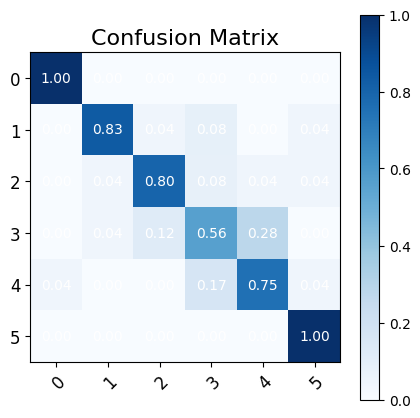

In [27]:
# normalize the confusion matrix
conf_matrix = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# plot the confusion matrix
fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(conf_matrix, cmap='Blues')

# set the axis labels
ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
ax.set_xticklabels(classes, fontsize=12)
ax.set_yticklabels(classes, fontsize=12)

# rotate the x-axis labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# set the text labels in each cell
for i in range(len(classes)):
    for j in range(len(classes)):
        text = ax.text(j, i, format(conf_matrix[i, j], '.2f'),
                       ha="center", va="center", color="white")

# set the plot title and show the color bar
ax.set_title("Confusion Matrix", fontsize=16)
plt.colorbar(im)

# display the plot
plt.show()